In [1]:
# Resources
# == https://jovian.ml/amvkind/titanic-data-pytorch
# == https://jovian.ml/undefined-none/titanic-logistic-regression
# == https://jovian.ml/fabianac07/linear-regresion-with-pytorch-titanic-dataset
# == https://jovian.ml/rksensational/05-assigment-project
# == https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8

# Uncomment and run the commands below if imports fail
!conda install numpy pytorch torchvision cpuonly -c pytorch -y
!pip install matplotlib --upgrade --quiet
!pip install pandas --upgrade --quiet
!pip install jovian --upgrade --quiet

Solving environment: ...working... done

# All requested packages already installed.



In [2]:
# Imports
import torch
import jovian
import torchvision
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [3]:
# Hyperparameters
batch_size = 5
learning_rate = 1e-2
threshold = 0.5
TARGET_COLUMN = 'Survived'
input_size = 6 # len(train_df.columns) - 1
output_size = 1

In [4]:
train_df = pd.read_csv('./train.csv')
# train_df = pd.read_csv('./Admission_Predict.csv')
# train_df.rename(columns={'Chance of Admit ':'Chance of Admission'}, inplace=True)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test_df = pd.read_csv('./test.csv')

test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
# Dataset Attributes
print("Training Dataset:", train_df.shape)
print("Testing Dataset:", test_df.shape)

print("Training Dataset Columns:", list(train_df.columns))
print("Testing Dataset Columns:", list(test_df.columns))

Training Dataset: (891, 12)
Testing Dataset: (418, 11)
Training Dataset Columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
Testing Dataset Columns: ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


In [7]:
# # Converts the string values in the 'Sex' column of the dataset to integers.
# # Male = 0
# # Female = 1

train_df['Sex'] = train_df['Sex'].map({'male': 0,'female': 1})
test_df['Sex'] = test_df['Sex'].map({'male': 0,'female': 1})

# # Removes all rows from the training dataset that contain the value NaN under the 'Age' column
train_df = train_df[train_df['Age'].notna()]
test_df = test_df[test_df['Age'].notna()]

In [8]:
# # Convert from Pandas dataframe to numpy arrays
inputs = train_df.drop(['PassengerId', 'Name', 'Ticket', 'Embarked', 'Cabin', TARGET_COLUMN], axis=1).values
targets = train_df[[TARGET_COLUMN]].values

inputs.shape, targets.shape

((714, 6), (714, 1))

In [9]:
# Reading train and test data
# df_train = pd.read_csv(PATH+'train.csv')  # 0 - 890
# df_test = pd.read_csv(PATH+'test.csv')  # 0 - 417
# df_train = shuffle(df_train)

# Adding a Survived column in test data 
lst = np.zeros(len(test_df), dtype=int)
test_df.insert(loc=1, column='Survived', value=lst)

# train_ds = TensorDataset(inputs[0:691], targets[0:691])
# val_ds = TensorDataset(inputs[691:891], targets[691:891]) 
# test_ds = TensorDataset(inputs[891:], targets[891:])

# batch_size=32
# train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
# val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
# test_loader = DataLoader(test_ds, 418, num_workers=4, pin_memory=True)

In [10]:
# Convert to PyTorch dataset

# dataset = TensorDataset(torch.tensor(inputs).float(), torch.from_numpy(targets).float())
# train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

dataset = TensorDataset(torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32))
# dataset = TensorDataset(torch.tensor(inputs).float(), torch.tensor(targets).float())
train_ds, val_ds = random_split(dataset, [614, 100])
# train_ds, val_ds = random_split(dataset, [300, 100])

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)

In [11]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[ 3.0000,  0.0000, 20.5000,  0.0000,  0.0000,  7.2500],
        [ 2.0000,  0.0000, 31.0000,  0.0000,  0.0000, 10.5000],
        [ 1.0000,  0.0000, 32.0000,  0.0000,  0.0000, 30.5000],
        [ 3.0000,  0.0000,  4.0000,  4.0000,  1.0000, 29.1250],
        [ 3.0000,  0.0000, 18.0000,  1.0000,  0.0000,  6.4958]])
targets: tensor([[0.],
        [0.],
        [1.],
        [0.],
        [0.]])


In [12]:
# Model
class TitanicModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, output_size)
#         self.linear1 = nn.Linear(input_size, 3)
#         self.linear2 = nn.Linear(3, output_size)
        
    def forward(self, xb):
        out = self.linear1(xb)
#         out = F.relu(out)
#         out = self.linear2(out)
        
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = F.l1_loss(out, targets)    # Calculate loss
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = F.l1_loss(out, targets)    # Calculate loss
        acc = accuracy(out, targets)           # Calculate accuracy
        
#         print("acc:", acc)
        
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        
#         print("epoch_acc:", epoch_acc)
        
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = TitanicModel()

In [13]:
# Training
def accuracy(outputs, labels):
        return torch.tensor(torch.sum(abs(outputs-labels) < 0.5).item() / len(outputs))
#     _, preds = torch.max(outputs, dim=1)
#     return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [14]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');
    
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [15]:
result = evaluate(model, val_loader)
# history = [evaluate(model, val_loader)]

result

{'val_loss': 2.805527448654175, 'val_acc': 0.09000001102685928}

In [16]:
# epochs_list = [500, 250, 125, 75]
# learning_rates = [0.00001, 0.0001, 0.001, 0.01]

epochs_list = [100, 100, 100, 100, 100]
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

In [17]:
history = fit(epochs_list[0], learning_rates[0], model, train_loader, val_loader)

Epoch [0], val_loss: 9.0833, val_acc: 0.0300
Epoch [1], val_loss: 1.5294, val_acc: 0.2900
Epoch [2], val_loss: 39.7608, val_acc: 0.0000
Epoch [3], val_loss: 28.1540, val_acc: 0.0000
Epoch [4], val_loss: 7.1435, val_acc: 0.0300
Epoch [5], val_loss: 6.3605, val_acc: 0.0200
Epoch [6], val_loss: 19.0929, val_acc: 0.0000
Epoch [7], val_loss: 7.2964, val_acc: 0.0700
Epoch [8], val_loss: 5.4706, val_acc: 0.0000
Epoch [9], val_loss: 12.8745, val_acc: 0.0000
Epoch [10], val_loss: 21.7362, val_acc: 0.0000
Epoch [11], val_loss: 14.3719, val_acc: 0.0000
Epoch [12], val_loss: 10.8340, val_acc: 0.0000
Epoch [13], val_loss: 33.3872, val_acc: 0.0000
Epoch [14], val_loss: 6.6364, val_acc: 0.0000
Epoch [15], val_loss: 2.9328, val_acc: 0.2500
Epoch [16], val_loss: 6.2933, val_acc: 0.0000
Epoch [17], val_loss: 1.8026, val_acc: 0.3300
Epoch [18], val_loss: 48.6416, val_acc: 0.0000
Epoch [19], val_loss: 19.1616, val_acc: 0.0300
Epoch [20], val_loss: 7.1239, val_acc: 0.1200
Epoch [21], val_loss: 1.9279, val_

In [18]:
history += fit(epochs_list[1], learning_rates[1], model, train_loader, val_loader)

Epoch [0], val_loss: 0.8254, val_acc: 0.5200
Epoch [1], val_loss: 0.5911, val_acc: 0.5800
Epoch [2], val_loss: 1.0352, val_acc: 0.2200
Epoch [3], val_loss: 2.3605, val_acc: 0.2700
Epoch [4], val_loss: 0.4926, val_acc: 0.4900
Epoch [5], val_loss: 0.8167, val_acc: 0.3300
Epoch [6], val_loss: 1.0799, val_acc: 0.1900
Epoch [7], val_loss: 1.3025, val_acc: 0.3300
Epoch [8], val_loss: 0.6661, val_acc: 0.4600
Epoch [9], val_loss: 1.1757, val_acc: 0.3700
Epoch [10], val_loss: 1.3124, val_acc: 0.1900
Epoch [11], val_loss: 1.2347, val_acc: 0.3900
Epoch [12], val_loss: 1.3600, val_acc: 0.3300
Epoch [13], val_loss: 0.8864, val_acc: 0.2700
Epoch [14], val_loss: 1.4528, val_acc: 0.1100
Epoch [15], val_loss: 2.5857, val_acc: 0.1300
Epoch [16], val_loss: 0.6784, val_acc: 0.4800
Epoch [17], val_loss: 1.4201, val_acc: 0.1700
Epoch [18], val_loss: 0.3753, val_acc: 0.7500
Epoch [19], val_loss: 1.4639, val_acc: 0.1400
Epoch [20], val_loss: 0.7020, val_acc: 0.6000
Epoch [21], val_loss: 1.9698, val_acc: 0.030

In [19]:
history += fit(epochs_list[2], learning_rates[2], model, train_loader, val_loader)

Epoch [0], val_loss: 0.3232, val_acc: 0.7700
Epoch [1], val_loss: 0.2956, val_acc: 0.7900
Epoch [2], val_loss: 0.3120, val_acc: 0.7700
Epoch [3], val_loss: 0.2999, val_acc: 0.7700
Epoch [4], val_loss: 0.4047, val_acc: 0.6400
Epoch [5], val_loss: 0.3978, val_acc: 0.6300
Epoch [6], val_loss: 0.3100, val_acc: 0.7900
Epoch [7], val_loss: 0.3231, val_acc: 0.7500
Epoch [8], val_loss: 0.3524, val_acc: 0.7000
Epoch [9], val_loss: 0.5212, val_acc: 0.5500
Epoch [10], val_loss: 0.3789, val_acc: 0.6600
Epoch [11], val_loss: 0.4097, val_acc: 0.6100
Epoch [12], val_loss: 0.3074, val_acc: 0.7400
Epoch [13], val_loss: 0.2988, val_acc: 0.7700
Epoch [14], val_loss: 0.3097, val_acc: 0.7500
Epoch [15], val_loss: 0.3240, val_acc: 0.7300
Epoch [16], val_loss: 0.2912, val_acc: 0.7800
Epoch [17], val_loss: 0.2935, val_acc: 0.7700
Epoch [18], val_loss: 0.4627, val_acc: 0.6200
Epoch [19], val_loss: 0.2881, val_acc: 0.7700
Epoch [20], val_loss: 0.2872, val_acc: 0.7900
Epoch [21], val_loss: 0.3057, val_acc: 0.780

In [20]:
history += fit(epochs_list[3], learning_rates[3], model, train_loader, val_loader)

Epoch [0], val_loss: 0.2641, val_acc: 0.8100
Epoch [1], val_loss: 0.2614, val_acc: 0.7900
Epoch [2], val_loss: 0.2697, val_acc: 0.7900
Epoch [3], val_loss: 0.2643, val_acc: 0.8100
Epoch [4], val_loss: 0.2625, val_acc: 0.7900
Epoch [5], val_loss: 0.2610, val_acc: 0.7900
Epoch [6], val_loss: 0.2858, val_acc: 0.7900
Epoch [7], val_loss: 0.2610, val_acc: 0.7900
Epoch [8], val_loss: 0.2617, val_acc: 0.8000
Epoch [9], val_loss: 0.2609, val_acc: 0.7900
Epoch [10], val_loss: 0.2620, val_acc: 0.7900
Epoch [11], val_loss: 0.2653, val_acc: 0.8000
Epoch [12], val_loss: 0.2628, val_acc: 0.8000
Epoch [13], val_loss: 0.2629, val_acc: 0.7900
Epoch [14], val_loss: 0.2612, val_acc: 0.7900
Epoch [15], val_loss: 0.2613, val_acc: 0.8000
Epoch [16], val_loss: 0.2626, val_acc: 0.8000
Epoch [17], val_loss: 0.2647, val_acc: 0.8000
Epoch [18], val_loss: 0.2617, val_acc: 0.7900
Epoch [19], val_loss: 0.2615, val_acc: 0.8000
Epoch [20], val_loss: 0.2639, val_acc: 0.7900
Epoch [21], val_loss: 0.2676, val_acc: 0.790

In [21]:
history += fit(epochs_list[4], learning_rates[4], model, train_loader, val_loader)

Epoch [0], val_loss: 0.2573, val_acc: 0.7900
Epoch [1], val_loss: 0.2571, val_acc: 0.7900
Epoch [2], val_loss: 0.2572, val_acc: 0.7900
Epoch [3], val_loss: 0.2574, val_acc: 0.7900
Epoch [4], val_loss: 0.2574, val_acc: 0.7900
Epoch [5], val_loss: 0.2573, val_acc: 0.7900
Epoch [6], val_loss: 0.2574, val_acc: 0.7900
Epoch [7], val_loss: 0.2574, val_acc: 0.7900
Epoch [8], val_loss: 0.2578, val_acc: 0.7900
Epoch [9], val_loss: 0.2574, val_acc: 0.7900
Epoch [10], val_loss: 0.2573, val_acc: 0.7900
Epoch [11], val_loss: 0.2572, val_acc: 0.7900
Epoch [12], val_loss: 0.2573, val_acc: 0.7900
Epoch [13], val_loss: 0.2577, val_acc: 0.7900
Epoch [14], val_loss: 0.2573, val_acc: 0.7900
Epoch [15], val_loss: 0.2573, val_acc: 0.7900
Epoch [16], val_loss: 0.2574, val_acc: 0.7900
Epoch [17], val_loss: 0.2574, val_acc: 0.7900
Epoch [18], val_loss: 0.2573, val_acc: 0.7900
Epoch [19], val_loss: 0.2575, val_acc: 0.7900
Epoch [20], val_loss: 0.2574, val_acc: 0.7900
Epoch [21], val_loss: 0.2574, val_acc: 0.790

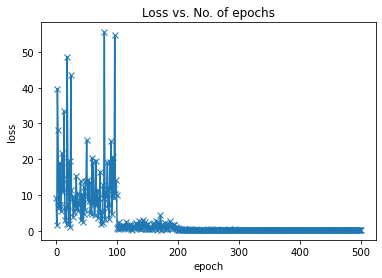

In [22]:
plot_losses(history)

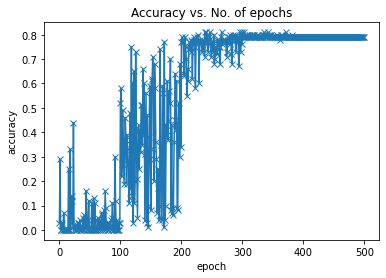

In [23]:
plot_accuracies(history)

In [24]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(input)                # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)
    if prediction >= 0.5:
      print('The passenger survived!')
    else:
      print('The passenger did not survive!')

In [25]:
test_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,Q
1,893,0,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,S
4,896,0,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,S


In [26]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([ 3.0000,  0.0000,  2.0000,  3.0000,  1.0000, 21.0750])
Target: tensor([0.])
Prediction: tensor(0.0127)
The passenger did not survive!


In [29]:
input, target = val_ds[40]
predict_single(input, target, model)

Input: tensor([ 2.,  1.,  4.,  2.,  1., 39.])
Target: tensor([1.])
Prediction: tensor(0.8199)
The passenger survived!


In [30]:
torch.save(model.state_dict(), 'titanic-dataset.pth')
jovian.log_metrics(val_acc = history[-1]['val_acc'], val_loss = history[-1]['val_loss'])
jovian.log_hyperparams(lr = learning_rates, epochs = epochs_list, batch_size = batch_size, loss_fun='l1_loss')
jovian.commit(files=['train.csv', 'test.csv'], project='titanic-dataset', environment=None, outputs=['titanic-dataset.pth'])

[jovian] Metrics logged.
[jovian] Hyperparams logged.


<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "pahuja-gor/titanic-dataset" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Uploading additional files...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/pahuja-gor/titanic-dataset


'https://jovian.ml/pahuja-gor/titanic-dataset'